## Step 3a: Develop models

**Project**: Predicting Bus Ridership \
**Team**: T20 - Eurus Li, Garrett Kent, Kate Munkacsy

### A. Initial setup

In [48]:
## UPDATE BEFORE RUNNING CODE
dir = "path/to/repo/"

In [49]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## package to help with group-based time series test-train splits
## source: https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits

### B. Import feature data

In [51]:
data = pd.read_csv(dir + "/Data/feature_matrix.csv")
data.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders
0,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.50
1,1,Ross,SAT.,3.54,34.6,2017,2,969.50,Winter,224.0,17.0,0,1238.75
2,1,Ross,SAT.,1.46,40.6,2017,3,1238.75,Spring,224.0,17.0,0,1178.25
3,1,Ross,SAT.,5.02,39.9,2017,4,1178.25,Spring,224.0,17.0,0,1285.20
4,1,Ross,SAT.,3.54,57.3,2017,5,1285.20,Spring,224.0,17.0,0,1235.50


### C. Prepare date chunking for train-test splits

In [53]:
## Create date column for indexing
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str).str.pad(2, 'left', '0')

## Sort by date
df_sorted = data.sort_values('date')
df_sorted = df_sorted.set_index('date')
df_sorted.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders
date,,,,,,,,,,,,,
2017-01,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.500000
2017-01,74,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,392.000000
2017-01,74,East Liberty,WEEKDAY,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,874.590909
2017-01,75,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1783.500000
2017-01,75,East Liberty,SUN.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1111.200000


In [54]:
## specify chunks for time series splits
cv_args = {"test_size": 1, "n_splits": 10}
tscv = GroupTimeSeriesSplit(**cv_args)
months = np.sort(df_sorted.index)
months

array(['2017-01', '2017-01', '2017-01', ..., '2024-10', '2024-10',
       '2024-10'], dtype=object)

### D. Establish feature and outcome dataframes

In [56]:
## establish feature and target dataframes
X = df_sorted.drop(['avg_riders'], axis = 1)
y = df_sorted['avg_riders']

## drop sparse columns
sparse_columns = list(X.columns[X.nunique() / len(X) * 100 < 0.01])
X = X.drop(sparse_columns, axis = 1)

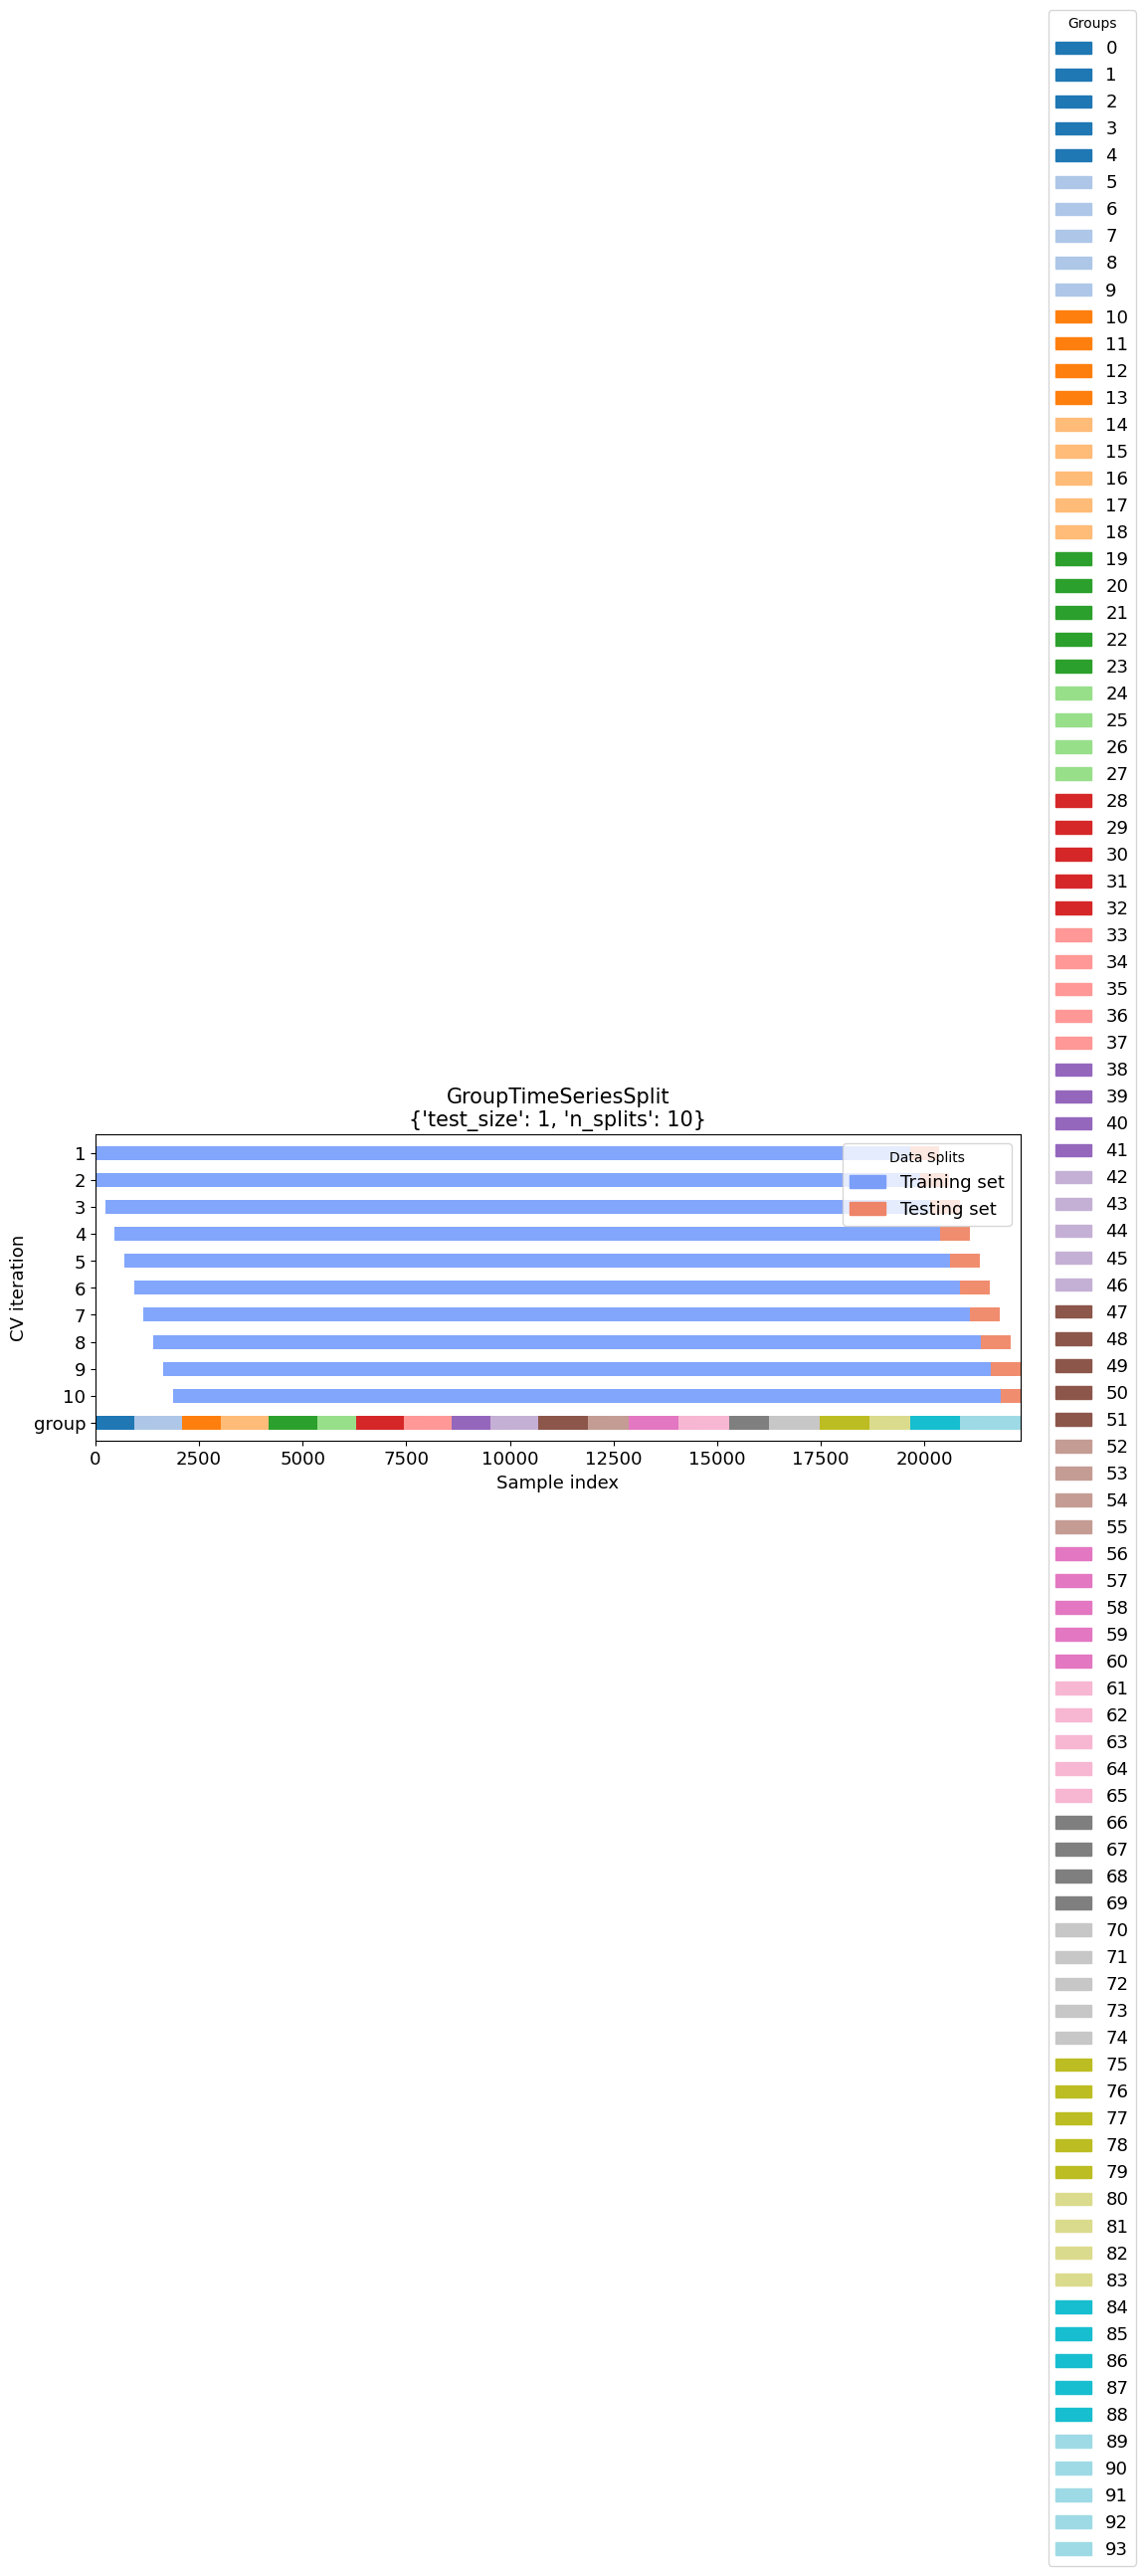

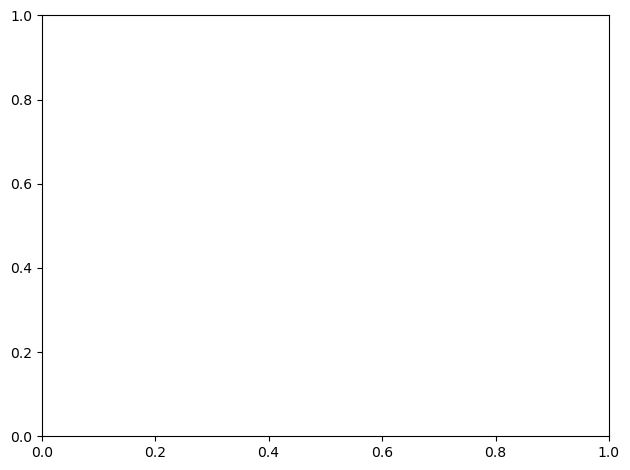

In [127]:
## plot train-test splits to show that each month (group) is represented entirely within one of the two sets
## data from the same month is never split across training and test
## testing data is always chronologically after training data
groups = [np.where(np.array(list(dict.fromkeys(months)))==e)[0][0]for e in months]
plot_splits(X, y, groups, **cv_args)
plt.tight_layout()

### E. Establish preprocessing and model details

Given the time series nature of the bus ridership data, we first considered various baseline models that we learned in our Decision & Risk Modeling course (90-775)
- weighted moving average
- exponential smoothing

We also calculated a simple mean baseline model before testing the following four methods:
- linear regression
- random forest
- XGBoost
- LightGBM

In [60]:
# establish baseline DRM models (WMA and exponential smoothing)
class WMARegressor(BaseEstimator, RegressorMixin):
    def __init__(self, weights=[0.6, 0.3, 0.1]):
        self.weights = weights

    def fit(self, X, y):
        self.weights_ = np.array(self.weights)
        self.window_ = len(self.weights_)
        self.y_train_ = np.asarray(y)
        return self

    def predict(self, X):
        # Only predict the LAST len(X) points
        preds = np.full(len(self.y_train_), np.nan)
        for i in range(self.window_, len(self.y_train_)):
            preds[i] = np.dot(self.y_train_[i - self.window_:i], self.weights_)

        # Return only the last len(X) predictions, corresponding to the test set
        return preds[-len(X):]
        return preds


class ExpSmoothingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, smoothing_level=None):
        self.smoothing_level = smoothing_level

    def fit(self, X, y):
        self.y_train_ = np.asarray(y)
        self.model_ = SimpleExpSmoothing(self.y_train_, initialization_method='estimated')
        self.fit_model_ = self.model_.fit(
            smoothing_level=self.smoothing_level,
            optimized=(self.smoothing_level is None)
        )
        return self

    def predict(self, X):
        # Predict using fitted values from training, return only as many as in X (the test set)
        fitted_values = self.fit_model_.fittedvalues
        return fitted_values[-len(X):]

In [61]:
def preprocess_steps(X):
    # Identify column types
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    # Preprocessing
    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])
    
    # Define XGBoost and LightGBM pipelines
    models = {
        "Baseline (Mean)": DummyRegressor(strategy='mean'), 
        "WMA (0.6, 0.3, 0.1)": Pipeline([
        ('model', WMARegressor(weights=[0.6, 0.3, 0.1]))
        ]),
        "Exponential Smoothing": Pipeline([
        ('model', ExpSmoothingRegressor(smoothing_level=None))  # Can tune this
        ]),
        "Linear Regression": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        "Random Forest": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=25, random_state=47, n_jobs=-1))
        ]),
        'XGBoost': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ]),
        'LightGBM': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ])
    }
    return models

### F. Fit models

In [63]:
# Dictionary to store RMSEs for each model
model_rmse_per_fold = {}

# Loop through each method to train models
models = preprocess_steps(X)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=tscv, groups=months, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_scores = -scores  # Convert from negative RMSE to RMSE
    model_rmse_per_fold[name] = rmse_scores  # Store
    print(f"{name:<25} | Mean RMSE: {rmse_scores.mean():>10,.3f} | Std: {rmse_scores.std():.3f}")
print("")

Baseline (Mean)           | Mean RMSE:  1,040.458 | Std: 80.941
WMA (0.6, 0.3, 0.1)       | Mean RMSE:  1,213.054 | Std: 113.548
Exponential Smoothing     | Mean RMSE:  1,015.144 | Std: 101.887
Linear Regression         | Mean RMSE:    280.342 | Std: 148.014
Random Forest             | Mean RMSE:    272.081 | Std: 134.029
XGBoost                   | Mean RMSE:    267.368 | Std: 138.848
LightGBM                  | Mean RMSE:    253.843 | Std: 149.861



### G. Visualize RMSE values

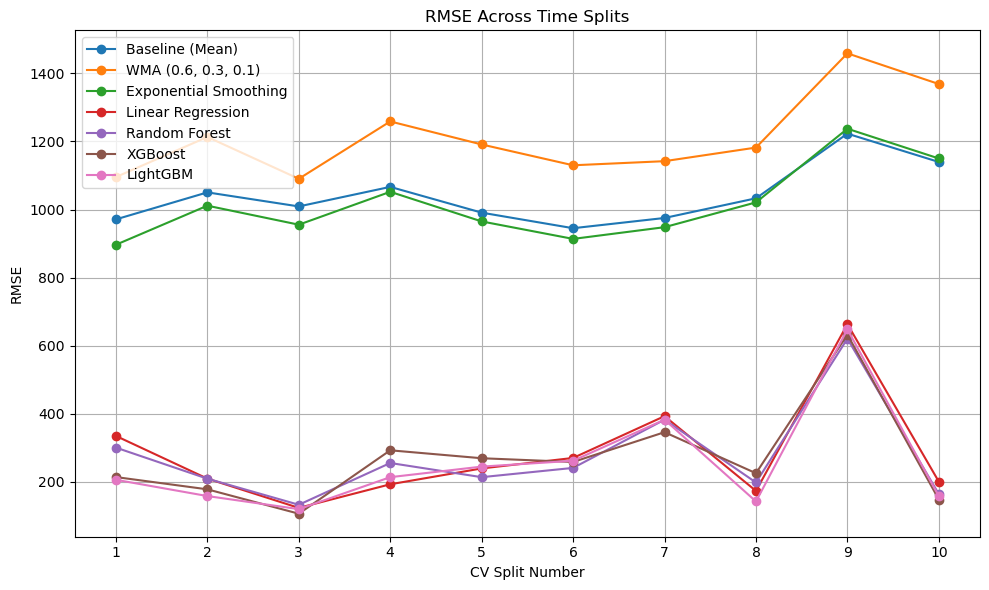

In [65]:
# Create a plot
plt.figure(figsize=(10, 6))

# For each model, plot the RMSE across the 10 CV folds
for model_name, rmses in model_rmse_per_fold.items():
    plt.plot(range(1, len(rmses)+1), rmses, marker='o', label=model_name)

plt.title('RMSE Across Time Splits')
plt.xlabel('CV Split Number')
plt.ylabel('RMSE')
plt.xticks(range(1, 11))  # 1 through 10
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### H. Hyperparameter Tuning 

Tweak hyperparameters for the best performing models: 
- LightGBM
- Random Forest
- XGBoost

#### LightGBM tuning

In [68]:
def make_lightgbm_pipeline(params=None):
    if params is None:
        params = {}
    
    # Identify column types
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])
    
    regressor = LGBMRegressor(random_state=42, **params)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    return pipeline

In [69]:
param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31},
    {'n_estimators': 300, 'learning_rate': 0.05, 'num_leaves': 64},
    {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 128},
    {'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 50},
    {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 15, 'max_depth': 5}
]

**LightGBM Tuning Results**

In [71]:
results = []

for i, params in enumerate(param_grid, 1):
    model = make_lightgbm_pipeline(params)
    scores = cross_val_score(model, X, y, cv=tscv, groups=months, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_scores = -scores
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    results.append((i, params, mean_rmse, std_rmse))
    print(f"Model {i} | Mean RMSE: {mean_rmse:.3f} | Std: {std_rmse:.3f} | Params: {params}")

Model 1 | Mean RMSE: 253.843 | Std: 149.861 | Params: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31}
Model 2 | Mean RMSE: 255.515 | Std: 146.822 | Params: {'n_estimators': 300, 'learning_rate': 0.05, 'num_leaves': 64}
Model 3 | Mean RMSE: 448.032 | Std: 94.145 | Params: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 128}
Model 4 | Mean RMSE: 251.234 | Std: 143.653 | Params: {'n_estimators': 500, 'learning_rate': 0.02, 'num_leaves': 50}
Model 5 | Mean RMSE: 271.074 | Std: 154.493 | Params: {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 15, 'max_depth': 5}


#### Random Forest tuning

In [73]:
def make_rf_pipeline(params=None):
    if params is None:
        params = {}
    
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])
    
    regressor = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    return pipeline

In [74]:
rf_param_grid = [
    {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2},
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10},
    {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2},
    {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5}
]

**Random Forest Tuning Results**

In [76]:
rf_results = []

for i, params in enumerate(rf_param_grid, 1):
    model = make_rf_pipeline(params)
    scores = cross_val_score(model, X, y, cv=tscv, groups=months, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_scores = -scores
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    rf_results.append((i, params, mean_rmse, std_rmse))
    print(f"RF Model {i} | Mean RMSE: {mean_rmse:.3f} | Std: {std_rmse:.3f} | Params: {params}")

RF Model 1 | Mean RMSE: 261.760 | Std: 138.316 | Params: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
RF Model 2 | Mean RMSE: 265.729 | Std: 137.645 | Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}
RF Model 3 | Mean RMSE: 267.073 | Std: 137.211 | Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}
RF Model 4 | Mean RMSE: 272.424 | Std: 144.492 | Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}
RF Model 5 | Mean RMSE: 266.268 | Std: 136.383 | Params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5}


#### XGBoost tuning

In [78]:
def make_xgb_pipeline(params=None):
    if params is None:
        params = {}
    
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])
    
    regressor = XGBRegressor(random_state=42, n_jobs=-1, **params)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    return pipeline

In [79]:
xgb_param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1},
    {'n_estimators': 200, 'learning_rate': 0.05},
    {'n_estimators': 300, 'learning_rate': 0.01},
    {'n_estimators': 150, 'learning_rate': 0.2},
    {'n_estimators': 250, 'learning_rate': 0.1}
]

**XGBoost Tuning Results**

In [81]:
xgb_results = []

for i, params in enumerate(xgb_param_grid, 1):
    model = make_xgb_pipeline(params)
    scores = cross_val_score(model, X, y, cv=tscv, groups=months, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_scores = -scores
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    xgb_results.append((i, params, mean_rmse, std_rmse))
    print(f"XGB Model {i} | Mean RMSE: {mean_rmse:.3f} | Std: {std_rmse:.3f} | Params: {params}")

XGB Model 1 | Mean RMSE: 267.368 | Std: 138.848 | Params: {'n_estimators': 100, 'learning_rate': 0.1}
XGB Model 2 | Mean RMSE: 263.281 | Std: 132.761 | Params: {'n_estimators': 200, 'learning_rate': 0.05}
XGB Model 3 | Mean RMSE: 274.999 | Std: 133.068 | Params: {'n_estimators': 300, 'learning_rate': 0.01}
XGB Model 4 | Mean RMSE: 264.801 | Std: 130.324 | Params: {'n_estimators': 150, 'learning_rate': 0.2}
XGB Model 5 | Mean RMSE: 270.448 | Std: 141.731 | Params: {'n_estimators': 250, 'learning_rate': 0.1}


### I. Use best model to make predictions

In [83]:
# Identify final month represented in the data
last_month = df_sorted.index.max()  # Assuming index = month
last_month

'2024-10'

In [84]:
# Use that final month for test set
is_test = df_sorted.index == last_month
is_train = ~is_test

X_train = X[is_train]
y_train = y[is_train]
X_test = X[is_test]

In [85]:
# Use best model (LightGBM) to make predictions
best_model = make_lightgbm_pipeline(params={
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31
})

best_model.fit(X_train, y_train)         # Pipeline handles preprocessing + model
y_pred = best_model.predict(X_test)      # Predict last month

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 22075, number of used features: 124
[LightGBM] [Info] Start training from score 1189.989572


In [86]:
# Get prediction
df_sorted.loc[is_test, 'y_pred'] = y_pred
df_sorted.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders,y_pred
date,,,,,,,,,,,,,,
2017-01,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.500000,NaN
2017-01,74,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,392.000000,NaN
2017-01,74,East Liberty,WEEKDAY,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,874.590909,NaN
2017-01,75,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1783.500000,NaN
2017-01,75,East Liberty,SUN.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1111.200000,NaN


In [87]:
# Save predication in separate dataframe
df_2024_10 = df_sorted.iloc[is_test]
df_2024_10

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders,y_pred
date,,,,,,,,,,,,,,
2024-10,60,West Mifflin,SUN.,1.9,69.4,2024,10,164.000000,Fall,97.0,5.0,0,146.500000,152.342019
2024-10,74,East Liberty,SAT.,1.9,69.4,2024,10,283.750000,Fall,177.0,6.0,0,335.750000,265.204705
2024-10,16,Ross,SUN.,1.9,69.4,2024,10,1178.666667,Fall,95.0,13.0,0,1160.500000,1146.695600
2024-10,74,East Liberty,WEEKDAY,1.9,69.4,2024,10,706.500000,Fall,177.0,6.0,0,742.043478,678.987882
2024-10,82,East Liberty,SAT.,1.9,69.4,2024,10,2680.750000,Fall,138.0,25.0,0,2512.250000,2544.176428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10,48,Collier,WEEKDAY,1.9,69.4,2024,10,1927.500000,Fall,91.0,11.0,0,1930.391304,1815.528620
2024-10,17,Ross,WEEKDAY,1.9,69.4,2024,10,1008.000000,Fall,102.0,12.0,0,967.000000,976.024757
2024-10,48,Collier,SUN.,1.9,69.4,2024,10,995.333333,Fall,91.0,11.0,0,890.750000,953.934737


In [88]:
predictions_2024_10 = df_2024_10[['route','day_type','y_pred']]
predictions_2024_10.head()

,route,day_type,y_pred
date,,,
2024-10,60,SUN.,152.342019
2024-10,74,SAT.,265.204705
2024-10,16,SUN.,1146.695600
2024-10,74,WEEKDAY,678.987882
2024-10,82,SAT.,2544.176428


### J. Identify routes with highest predicted ridership

In [90]:
top_n = 5  # change this to 5, 10, etc. if desired

top_routes = (
    predictions_2024_10
    .sort_values('y_pred', ascending=False)
    .groupby('day_type')
    .head(top_n)
    .sort_values(['day_type', 'y_pred'], ascending=[True, False])
)

top_routes

,route,day_type,y_pred
date,,,
2024-10,RED,SAT.,4798.685798
2024-10,51,SAT.,4031.413989
2024-10,61C,SAT.,3884.632817
2024-10,71B,SAT.,3388.877370
2024-10,P1,SAT.,3355.894545
2024-10,RED,SUN.,3665.194252
2024-10,51,SUN.,2882.950096
2024-10,61C,SUN.,2616.298933
2024-10,61A,SUN.,2380.921278


In [92]:
# Step 1: Group by route and calculate average predicted value
avg_preds = (
    predictions_2024_10
    .groupby(['route'])['y_pred']
    .mean()
    .reset_index()
)

avg_preds = avg_preds.rename(columns={'y_pred': 'avg_predicted_ridership'})

# Step 3: Sort by the average predicted value
avg_preds_sorted = avg_preds.sort_values('avg_predicted_ridership', ascending=False)

# Step 4: Display the top 10
top_10 = avg_preds_sorted.head(10)

# Preview results
top_10

,route,avg_predicted_ridership
92,RED,4315.781217
29,51,4095.593988
44,61C,3926.211187
42,61A,3558.782615
78,P1,3477.103887
53,71B,3392.638835
43,61B,3166.685227
54,71C,2795.555222
62,82,2689.133251
45,61D,2484.197163


In [125]:
# Output top 10 routes for additional analyses
top_10.to_csv(dir + "/Data/top10_routes.csv")